## Loading state sentiment scores

In [25]:
import json
stateScores= json.load(open('game2_q1aShortSent.txt'))

Now we'll import the state coordinates in Bokeh and see if we can scatter these '

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib nbagg

In [27]:
#Load raw data into dataframe
df= pd.DataFrame.from_dict(stateScores, orient= 'index')

In [28]:
df2= df.transpose()
df2.head(3)

,WA,DE,DC,WI,WV,HI,FL,WY,NH,NJ,...,MN,MI,KS,MT,MP,MS,SC,KY,OR,SD
0,0,0,-1,0,2,-1,-1,NaN,0,8,...,1,0,0,5,NaN,0,0,0,1,0
1,2,NaN,0,0,-3,1,-2,NaN,NaN,-8,...,2,0,0,NaN,NaN,0,-1,0,0,NaN
2,0,NaN,1,4,-1,NaN,0,NaN,NaN,2,...,0,-1,-4,NaN,NaN,0,5,0,0,NaN


In order to visualize the data on a map easily, we'll drop the non-continental states and territories. First we'll drop them from the map coordinates from bokeh, and then from the dataframe df2.

In [29]:
#First delete/exclude from the bokeh coordinate dictionary and sort them alphabetically
from bokeh.plotting import figure, show, output_file
from bokeh.sampledata.us_states import data as states

del states["HI"]
del states["AK"]

EXCLUDED = ("ak", "hi", "pr", "gu", "vi", "mp", "as")#Exclude territories

import collections#This will allow us to order our states to match coordinates of coord library with data

ordStates= collections.OrderedDict(sorted(states.items()))

In [30]:
#Now exclude Hawaii, Alaska, and territories from our dataframe
df3= df2.drop(['HI','AK','PR','GU','VI','MP','AS','NA'], axis= 1)#For some reason we also have a 'NA' column, drop that too

Now we'll count the number of tweets in in each state in df3 and calculate the mean tweet score for all the columns/states/series (will ignore NaN's, but output is NaN if the list for a state was empty). 

In [31]:
dfCount= df3.count()
dfMean= df3.mean()
#zip(dfCount, dfMean)

So now we have three dataframes: df3 = filtered data, dfCount = tweet count for each state in df3, dfMean= mean tweet score for each state in df3.  We'll use these to build our map and <strong>scale and normalize our tweet sentiment score data</strong>.
Since some of our values are negative, we'll account for that as well.

In [32]:
#First I'll convert this to a dictionary to play with just the values and order the dictionary to match ordStates
dfMeanDict= dfMean.to_dict()
ordMeanDict= collections.OrderedDict(sorted(dfMeanDict.items()))

#I'll also turn the item values into lists to make it easy to normalize scores
ordScoreKey= ordMeanDict.keys()
ordMeanScore= ordMeanDict.values()

#Now we'll calculate the min scores to help us normalize the data
minScore= min(ordMeanScore)

In [33]:
#The min and max values in our lexicon are -5 and +5
#Thus, first we'll make all values positive by adding 5, and normalize by dividing by 10
normScores= ordMeanScore#Shifts baseline scores by absolute value of minimum score 

In [34]:
#Get weight after converting count dictionary and sorting based on key, then taking values like we did with scores
weights= dfCount.to_dict()#Convert to dict
orderedCounts= collections.OrderedDict(sorted(weights.items())).values()#Sort dict by key, take values list
weights= np.float64(orderedCounts)/max(orderedCounts)#Normalize weight by max value

In [35]:
#Let's check if our dictionaries match
#zip(ordScoreKey,ordStates.keys())

Great. Now we have a sorted dictionary for our state coordinates (ordStates), a list of normalized tweetscores whose values match the order of the dictionary (normScores), and a list of corresponding weights for said scores (weights). We can now visualize the data! 

In [36]:
#Here, we'll split the coordinates of all the states into x,y lists and initialize our figure object
state_xs = [ordStates[code]["lons"] for code in ordStates]
state_ys = [ordStates[code]["lats"] for code in ordStates]

Now we'll generate a list of colors that we'll use to represent tweet score values. We'll use the cmap object to return a RGBA value depending on what value from 0 to 1 we feed it from our normalized tweet score list. 

In [37]:
#Below we'll set the range for the colormap that we use
#Although min and max values for sentiments are -5, and +5, 
#it'll be much easier to visualize changes if we narrow the working range, say to -1.5:1.5
import matplotlib
norm = matplotlib.colors.Normalize(vmin=-1.5, vmax=1.5)

cmap= matplotlib.cm.get_cmap('bwr')#Initialize cmap object

In [67]:
#Now we'll use this cmap object to take our normalized scores and assign a color to them in hex format
colorScore= []#Initialize list
for i in range(0,len(normScores)):
    if np.isnan(normScores[i]):#If the normScores value is nan (no tweets), return black (not in colormap)
        colorScore.append('#000000')
        
    else:
        colorScore.append(matplotlib.colors.rgb2hex(cmap(norm(normScores[i]))[:3]))

Bokeh has a little bit of problems adding colorbars to figures. Thus, we'll generate a colorbar using matplotlib
and scale it using the same max/min we used above. I'll save/crop the figure colorbar and save it as a png
in Dropbox and add the link to reference it for every state.

<IPython.core.display.Javascript object>


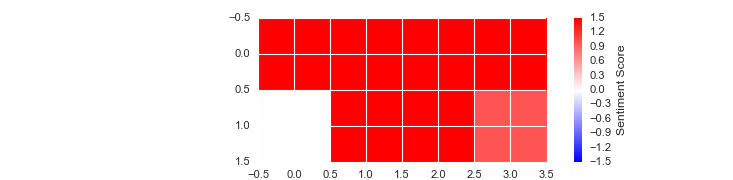

In [69]:
#Just making a matrix to be able to use the colorbar. Made sure to use the same cmap and vmin/vmax range as above!
data= np.array([[3,2,3,4],[0,3,4,1]])
plt.imshow(data, vmin = -1.5, vmax = 1.5, cmap = 'bwr', interpolation = 'nearest')
plt.colorbar(label = 'Sentiment Score')

#Finally here we'll get the address for an image of our colorbar that will pop up with all of the hovertool data for every state
scalebar= 'https://db.tt/5LGfM4dz'
stateUrls= [scalebar]*49

### Choropleth of Sentiment Scores

Now we'll use Bokeh to make a choropleth plot that displays the name of each state along with its corresponding tweet count and sentiment score. Unlike in previous Bokeh plots we've made, since our HoverTool tooltips feature will contain the scalebar image, all of the data in the ColumnDataSource will need to be called using HTML commands.  

In [64]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool

#We'll now make the source for the info on our hover
source= ColumnDataSource(data= dict(stateKey=ordScoreKey, counts=orderedCounts, score=ordMeanScore, scale= stateUrls))


hover= HoverTool(tooltips= '''
                 <div><label style='font-size: 17px; font-family: Arial; font-weight: bold;'>State: <span style="font-size: 17px; font-family: Arial; font-weight: normal;">@stateKey</span></label></div>
                 <div><label style='font-size: 17px; font-family: Arial; font-weight: bold;'>Count: <span style="font-size: 17px; font-family: Arial; font-weight: normal;"">@counts</span></label></div>
                 <div><label style='font-size: 17px; font-family: Arial; font-weight: bold;'>Sent Score: </label></div>
                 <div><span style="font-size: 17px; font-family: Arial; font-weight: normal;">@score</span></div>
                 <div><img src= '@scale'</img><div>                
          
'''
)

p = figure(title="Twitter Sentiment Scores for ", tools=[hover, 'wheel_zoom', 'pan', 'reset'], toolbar_location="left",
           plot_width=1100, plot_height=700)

#Plot map and use color list to assign colors to each state
p.patches(state_xs, state_ys, line_color= 'black', color= colorScore, source= source)#, fill_alpha= alphaWeights)
#This part here is the tricky part ,we must take the order listed by states and match it with our score/weight order

output_file("choropleth.html", title="choropleth.py example")
show(p)

### The following will be additional analysis for the scatterplots for just a few teams/states

In [ ]:
df3= df2[['CA','OK','VA','DC','OH']]
df3.tail(3)
sns.violinplot(df3)#This works but sns.swarmplot doesn't says index 166 out of bounds?
sns.boxplot(df3)#Look here: http://web.stanford.edu/~mwaskom/software/seaborn/generated/seaborn.swarmplot.html 
plt.ylabel('Tweet Sentiment Score')

### Analysis of extra data

In [85]:
import json
q1= json.load(open('game5_q1Sent.txt'))
q2= json.load(open('game5_q2Sent.txt'))
q3= json.load(open('game5_q3Sent.txt'))
q4= json.load(open('game5_q4Sent.txt'))

In [86]:
q1Sent= game1.values()
q1Sent= [j for i in q1Sent for j in i]

In [87]:
q2Sent= game2.values()
q2Sent= [j for i in q2Sent for j in i]

q3Sent= game3.values()
q3Sent= [j for i in q3Sent for j in i]

q4Sent= game4.values()
q4Sent= [j for i in q4Sent for j in i]

In [88]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib nbagg

<IPython.core.display.Javascript object>


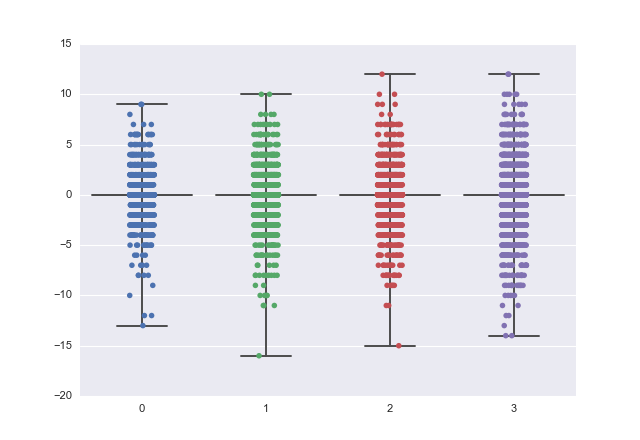

In [98]:
figure= sns.boxplot(data= [q1Sent, q2Sent, q3Sent, q4Sent])
sns.stripplot(data= [q1Sent, q2Sent, q3Sent, q4Sent], jitter= True)

<IPython.core.display.Javascript object>


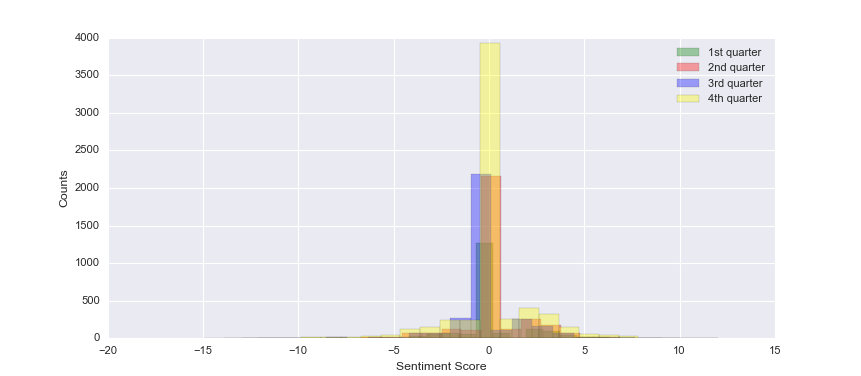

In [97]:
plt.hist(q1Sent, color= 'green', alpha= 0.35, bins= 25, label= '1st quarter')
plt.hist(q2Sent, color= 'red', alpha= 0.35, bins= 25, label = '2nd quarter')
plt.hist(q3Sent, color= 'blue', alpha= 0.35, bins= 25, label= '3rd quarter')
plt.hist(q4Sent, color= 'yellow', alpha= 0.35, bins= 25, label= '4th quarter')

plt.xlabel('Sentiment Score')
plt.ylabel('Counts')
plt.legend()

<IPython.core.display.Javascript object>


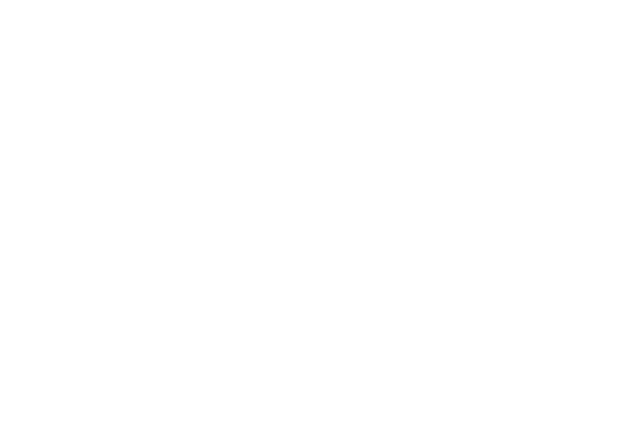

In [29]:
import matplotlib.pyplot as plt
import numpy as np

from bokeh import mpl
from bokeh.plotting import output_file, show

x = np.linspace(-2 * np.pi, 2 * np.pi, 100)
y = np.sin(x)
z = np.cos(x)

plt.plot(x, y, "r-", marker='o')
plt.title("Matplotlib Figure in Bokeh")

# dashed lines work
plt.plot(x, z, "g-x", linestyle="-.")

output_file("mpl_plot.html", title="mpl_plot.py example")

show(mpl.to_bokeh())